<br>

Задача построить прозноз продаж на ближайшие несколько месяцев. <br>
Понять сезонность бизнеса и общий тренд.

#### Импортирую библиотеки и подготавливаю данные для анализа

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from prophet import Prophet
import os
import warnings

%matplotlib inline

In [43]:
warnings.simplefilter(action='ignore', category=FutureWarning)

Импортирую данные

In [44]:
row_data = pd.read_csv(os.getcwd() + '/rsales.csv', sep=',', index_col=0)

In [45]:
row_data.head()

,date,sum_per_month,count_per_month
0,2018-01-01,672616,31
1,2018-01-02,720731,9
2,2018-01-03,1029296,35
3,2018-01-04,1916673,4
4,2018-01-05,1104135,26


Привожу данные в нужный формат

In [46]:
row_data['date'] = pd.to_datetime(row_data['date'], format='%Y-%d-%m')

In [47]:
row_data.dtypes

date               datetime64[ns]
sum_per_month               int64
count_per_month             int64
dtype: object

Делаю разметку данных

In [48]:
df = row_data[['date', 'sum_per_month']]
df.columns = ['ds', 'y']

In [49]:
df.head()

,ds,y
0,2018-01-01,672616
1,2018-02-01,720731
2,2018-03-01,1029296
3,2018-04-01,1916673
4,2018-05-01,1104135


Создаю датафрейм, чтобы передать в качестве параметров сезонность

In [50]:
holidays_dates = holidays.RU(years=(2015, 2016, 2017, 2018, 2019, 2020, 2021))
holidays_data = pd.DataFrame.from_dict(holidays_dates, orient='index').reset_index()
holidays_data.columns = ['ds', 'holiday']
holidays_data['ds'] = pd.to_datetime(holidays_data.ds)
holidays_data = holidays_data.sort_values(by=['ds'])
holidays_data = holidays_data.reset_index(drop=True)

In [51]:
holidays_data.tail()

,ds,holiday
93,2021-03-08,День женщин
94,2021-05-01,Праздник Весны и Труда
95,2021-05-09,День Победы
96,2021-06-12,День России
97,2021-11-04,День народного единства


<br>

#### Тренировка рабочей модели

Делаю разметку данных, чтобы провести тренировку модели. <br>
И отрезаю последние 3 месяца, чтобы чуть позже рассчитать ее погрешность.

In [52]:
predictions = 3

In [53]:
train_df = df[:-predictions]

In [54]:
df.tail()

,ds,y
26,2020-03-01,1901938
27,2020-04-01,580401
28,2020-05-01,232846
29,2020-06-01,1972417
30,2020-07-01,77879


Хочу взглянуть, что вцелом происходит с продажами

In [55]:
sns.set(rc={'figure.figsize':(12,5)})

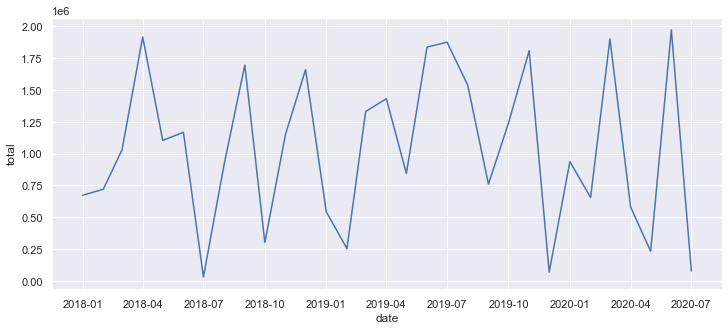

In [56]:
sns.lineplot(x='ds', y='y', data=df) \
    .set(xlabel="date", ylabel = "total");

Нужно найти изменения в продажах

In [57]:
df.sort_values(by='y').head(5).reset_index(drop=True)

,ds,y
0,2018-07-01,31221
1,2019-12-01,68208
2,2020-07-01,77879
3,2020-05-01,232846
4,2019-02-01,253447


Теперь настраиваю модель с учетом сезонности и падениями в продажах. <br>
Нет задачи посчитать супер точно, поэтому беру только первые две даты.

In [58]:
m = Prophet(holidays=holidays_data, 
            daily_seasonality=False, 
            weekly_seasonality=True, 
            yearly_seasonality=False, 
            changepoints=['2018-07-01', '2019-12-01'])

Запускаю тренировочную модель

In [59]:
m.fit(train_df);


Initial log joint probability = -75.486
Iteration  1. Log joint probability =    12.2025. Improved by 87.6885.
Iteration  2. Log joint probability =    21.3372. Improved by 9.13465.
Iteration  3. Log joint probability =    22.1412. Improved by 0.80408.
Iteration  4. Log joint probability =    22.3049. Improved by 0.163682.
Iteration  5. Log joint probability =    22.4088. Improved by 0.103927.
Iteration  6. Log joint probability =    22.4199. Improved by 0.0110954.
Iteration  7. Log joint probability =    22.4346. Improved by 0.0146435.
Iteration  8. Log joint probability =    22.4539. Improved by 0.0193328.
Iteration  9. Log joint probability =    22.4549. Improved by 0.000936533.
Iteration 10. Log joint probability =    22.4592. Improved by 0.00434386.
Iteration 11. Log joint probability =    22.4598. Improved by 0.000563111.
Iteration 12. Log joint probability =    22.4604. Improved by 0.000650515.
Iteration 13. Log joint probability =    22.4608. Improved by 0.000365266.
Iteration

In [60]:
df.tail()

,ds,y
26,2020-03-01,1901938
27,2020-04-01,580401
28,2020-05-01,232846
29,2020-06-01,1972417
30,2020-07-01,77879


Теперь нужно построить прогноз и посмотреть предварительные результаты

In [61]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

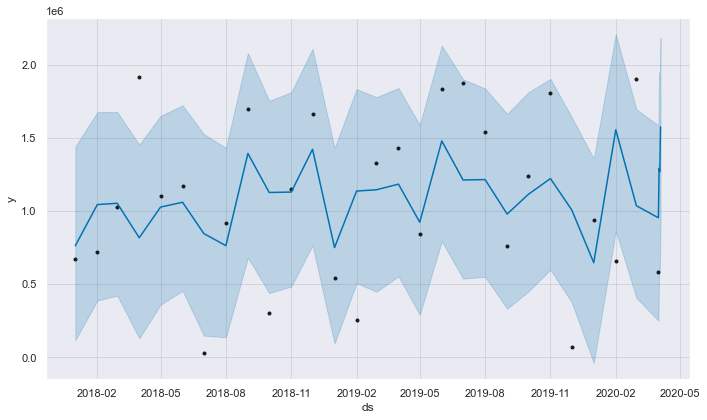

In [62]:
m.plot(forecast);

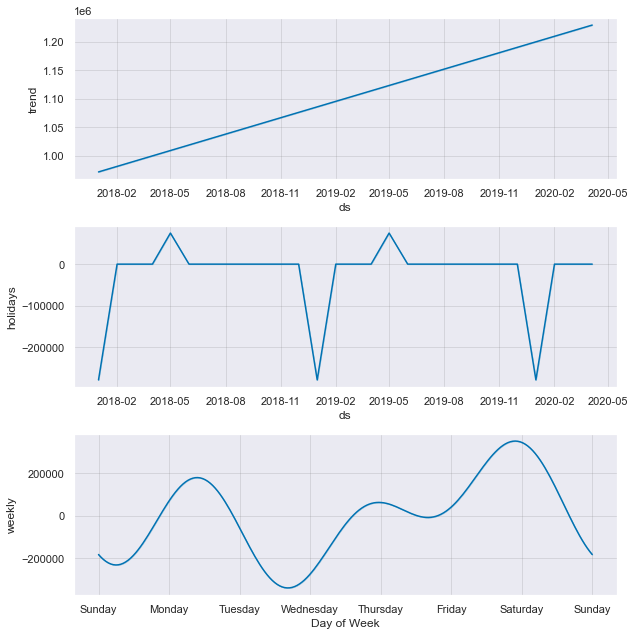

In [63]:
m.plot_components(forecast);

Полученные результаты не подходят, чтобы давать какие-то прогнозы, зато можно увидеть некоторые наблюдения: <br><br>
* Есть положительный тренд по продажам от 1 млн до 1,2 млн; <br>
* И продажи идут лучше всего в субботу и понедельник, а хуже всего в четверг; <br> 
* Видно, некоторую сезонность - законеморное повышение продаж в мае, и резкое падение продаж в январе.

<br>

#### Делаю расчет погрешности полученной модели

In [68]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [69]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']

In [70]:
# cmp_df[cmp_df.y == 0]

In [71]:
cmp_df.loc[~np.isfinite(cmp_df.p)] = np.nan
cmp_df = cmp_df.dropna()

Насколько модель ошибается в процентах

In [33]:
print(f'{round(np.mean(abs(cmp_df[-predictions:]["e"])))} mean absolute error')

712818 mean absolute error


Насколько модель ошибается в абсолютных значения

In [31]:
print(f'{round(np.mean(abs(cmp_df[-predictions:]["p"])))}% mean absolute percentage error')

82% mean absolute percentage error


<br>

#### Теперь задача построить финальный прогноз

Чтобы результаты был более точным разработчики рекомеднуют брать интервал в 3 месяца

In [75]:
predicted_months = 3

In [76]:
final_train_df = df

Настраиваю еще раз модель

In [77]:
f = Prophet(holidays=holidays_data, 
            daily_seasonality=False, 
            weekly_seasonality=True, 
            yearly_seasonality=False, 
            changepoints=['2018-07-01', '2019-12-01'])

f.fit(final_train_df);


Initial log joint probability = -79.607
Iteration  1. Log joint probability =   -4.77361. Improved by 74.8334.
Iteration  2. Log joint probability =    20.9038. Improved by 25.6774.
Iteration  3. Log joint probability =    22.3438. Improved by 1.44004.
Iteration  4. Log joint probability =    22.5828. Improved by 0.238964.
Iteration  5. Log joint probability =    22.7765. Improved by 0.193697.
Iteration  6. Log joint probability =    22.9762. Improved by 0.199726.
Iteration  7. Log joint probability =    23.0933. Improved by 0.117023.
Iteration  8. Log joint probability =    23.1151. Improved by 0.0218049.
Iteration  9. Log joint probability =    23.1418. Improved by 0.0267488.
Iteration 10. Log joint probability =    23.3824. Improved by 0.240631.
Iteration 11. Log joint probability =    23.5395. Improved by 0.157045.
Iteration 12. Log joint probability =    24.1002. Improved by 0.560746.
Iteration 13. Log joint probability =    24.1694. Improved by 0.0691383.
Iteration 14. Log joint

Запускаю функцию, чтобы построить новый прозноз на следующие 3 месяца

In [78]:
final_future = f.make_future_dataframe(periods=predicted_months)
final_forecast = f.predict(final_future)

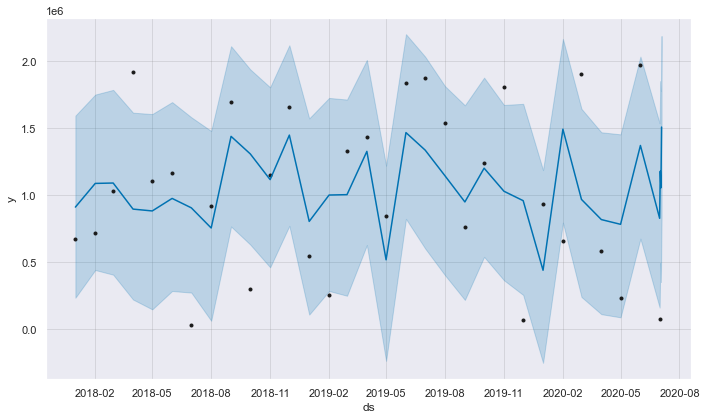

In [79]:
f.plot(final_forecast);

В результате получаю более сдержанный прогноз: <br><br>
* Положительный тренд от 1 млн до 1,18 млн <br>
* Рост продаж в июне до 1,3 млн, а затем снижение к концу июня до 0,8 млн 
* Дальнейшее повышение продаж до 1,5 млн после первых чисел июля

<br>

#### * Ниже строю интерактивынй график, который работает только в Jupyter Notebook

Подгружаю дополнительные библиотеки

In [82]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

In [83]:
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat'], name='yhat'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=final_forecast['ds'], y=final_forecast['trend'], name='trend')
])

In [41]:
# final_forecast.to_excel("./app_forecast.xlsx", sheet_name='Data', index=False, encoding="cp1251")